In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

from QRSDetectorOffline import QRSDetectorOffline


root_dir = "/work3/s174159/data/"
ecg_path = root_dir + "05/02/viatom-raw.csv"
index_path = root_dir + "05/02/c920.csv"


index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
df = pd.read_csv(ecg_path)

lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]
df["Lead"] = lead_names * (len(df) // 5)
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000  # Convert time.

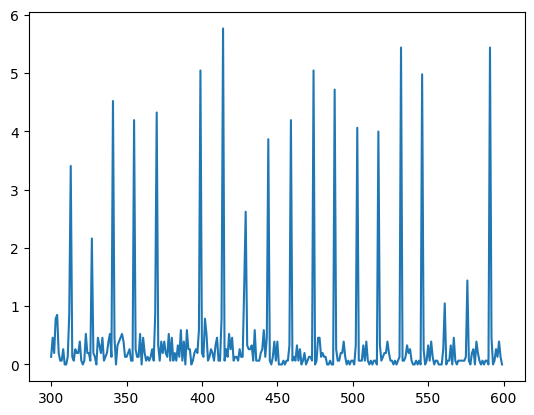

In [94]:
x = df[df['Lead'] == "Lead II"][" ECG"].reset_index()
y = df[df['Lead'] == "Lead I"][" ECG"].reset_index()

signal = x - y
signal = signal.drop(columns="index")
signal.to_csv('hi2.csv')
plt.plot(abs(signal[300:600] / 1e6))
plt.show()

In [3]:
signal

,ECG
0,196608
1,-458752
2,-65536
3,0
4,0
...,...
2318,196608
2319,-524288
2320,-1769472
2321,-131072


qrs peaks indices
[  60  116  199  245  304  346  419  479  538  597  662  721  779  848
  929  970 1024 1092 1133 1186 1239 1305 1383 1459 1523 1585 1649 1752
 1816 1869 1920 1996 2048 2111 2176 2225 2289]
noise peaks indices
[]


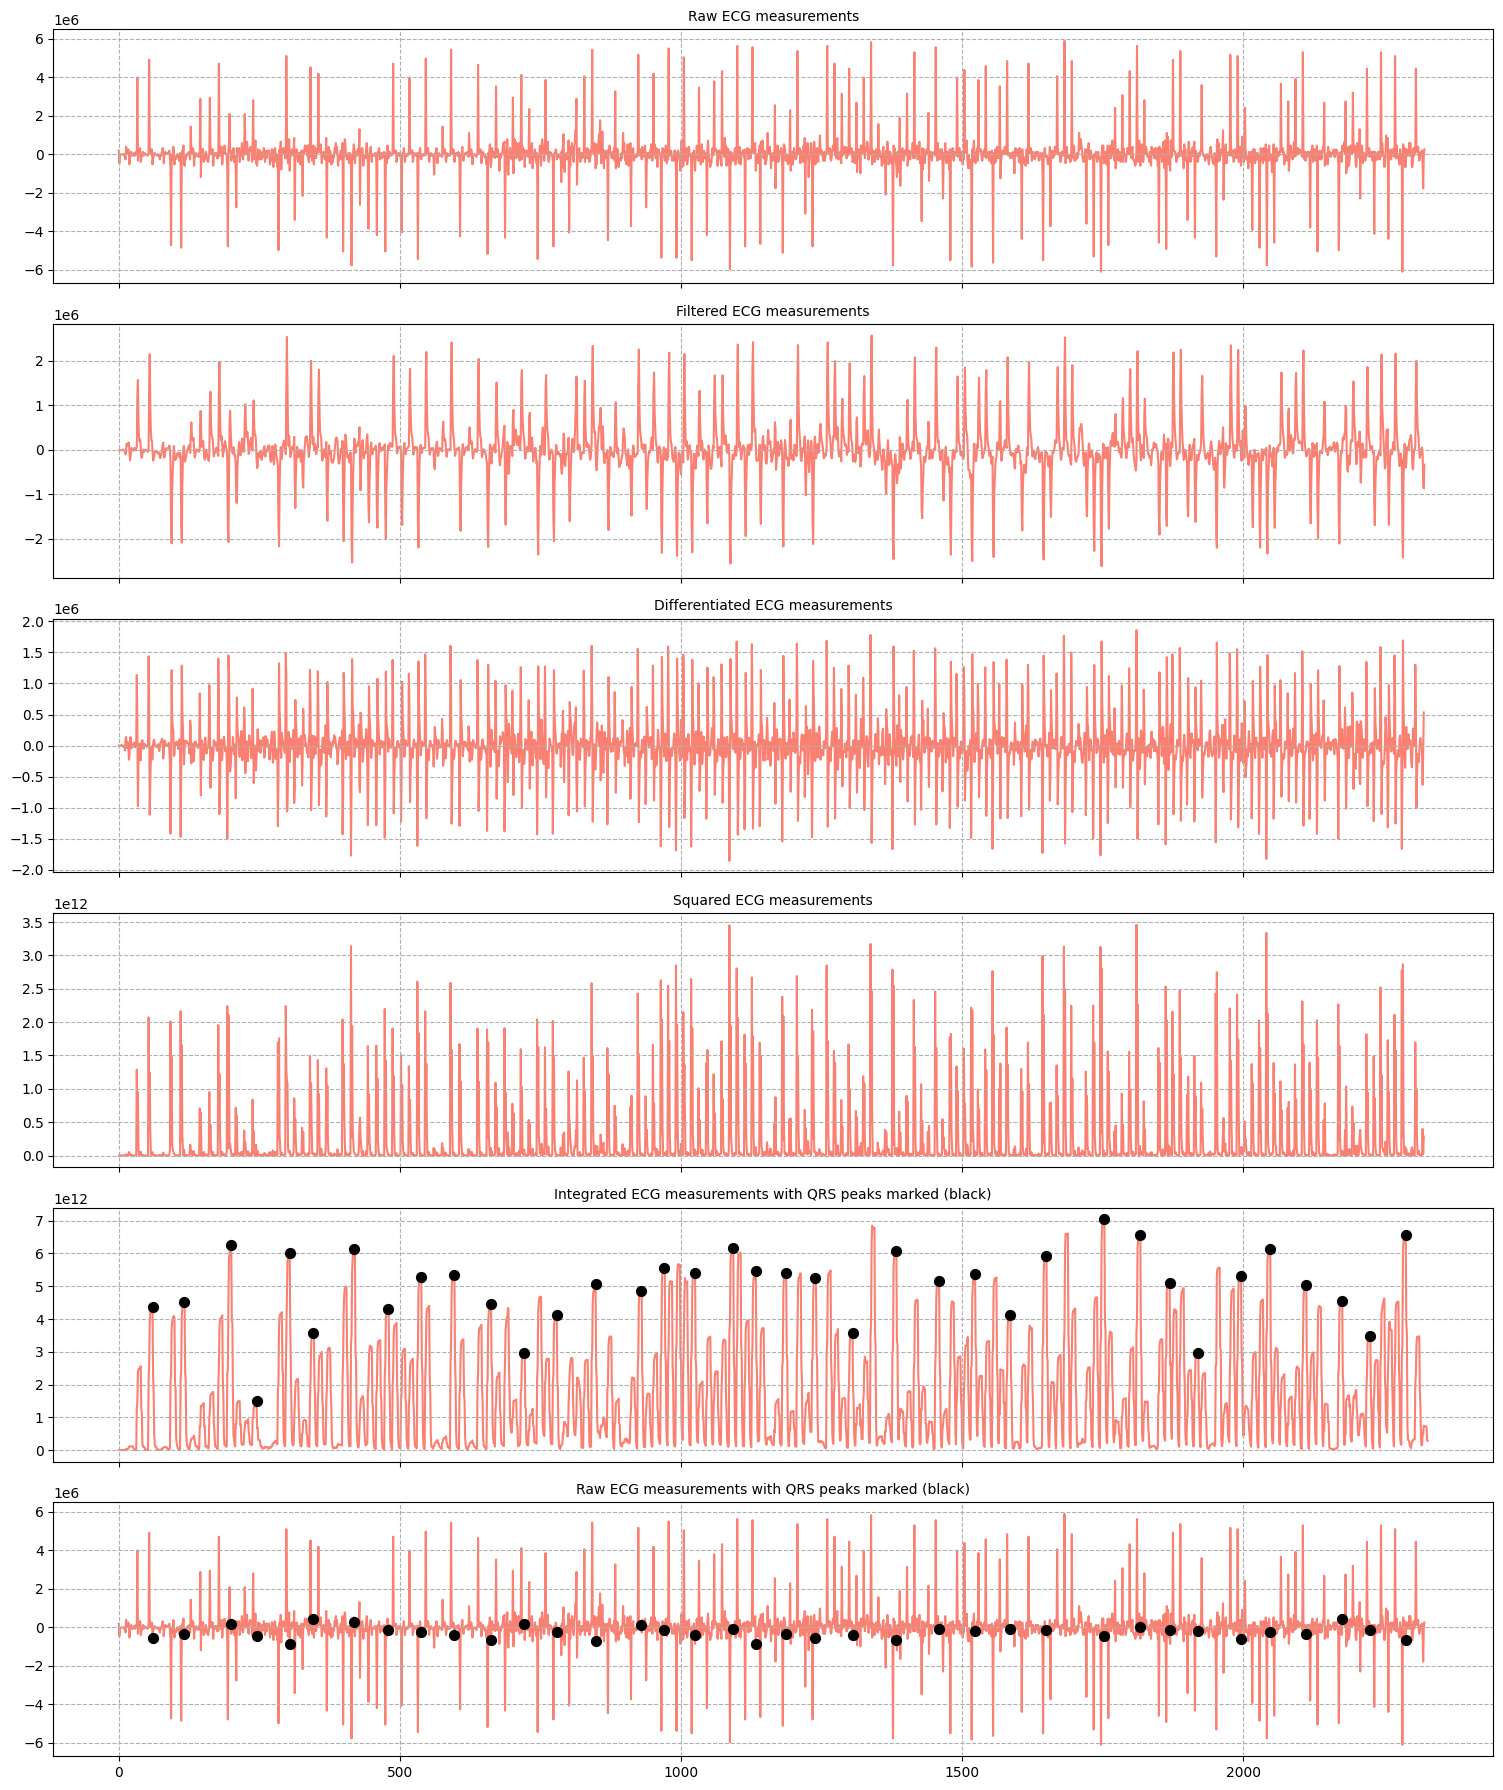

In [4]:
qrs_detector = QRSDetectorOffline(ecg_data_path="hi2.csv", verbose=True, log_dir="logs",
                                  log_data=True, plot_data=True, show_plot=True)

In [6]:
peaks = [  60,  116,  199,  245,  304,  346,  419,  479,  538,  597,  662,  721,  779,  848,
  929,  970, 1024, 1092, 1133, 1186, 1239, 1305, 1383, 1459, 1523, 1585, 1649, 1752,
 1816, 1869, 1920, 1996, 2048, 2111, 2176, 2225, 2289,]

In [9]:
bpms = [120/(peaks[i+1]- peaks[i])*60 for i in range(len(peaks)-1)]

In [11]:
np.mean(bpms)

120.96379617924634

In [14]:
df.describe()

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,time
count,1.161500e+04,1.161500e+04,11615.000000,11615.0,11615.0,11615.0,11615.0,11615.000000
mean,1.523615e+12,1.148220e+04,107.976324,-56.0,-1.0,-1.0,0.0,46.432023
std,2.682423e+04,1.833797e+06,10.057046,0.0,0.0,0.0,0.0,26.824233
min,1.523615e+12,-3.080192e+06,86.000000,-56.0,-1.0,-1.0,0.0,0.000000
25%,1.523615e+12,-9.175040e+05,101.000000,-56.0,-1.0,-1.0,0.0,23.192000
50%,1.523615e+12,-4.587520e+05,111.000000,-56.0,-1.0,-1.0,0.0,46.431000
75%,1.523615e+12,2.621440e+05,117.000000,-56.0,-1.0,-1.0,0.0,69.671000
max,1.523615e+12,1.120666e+07,119.000000,-56.0,-1.0,-1.0,0.0,92.871000


In [16]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [48]:
fs = 120
lowcut = 0.1
highcut = 15

filtered_outputs = butter_bandpass_filter(abs(signal[300:600]), lowcut, highcut, fs, order=4)
filtered_outputs = (filtered_outputs - np.mean(filtered_outputs)) / np.std(filtered_outputs)

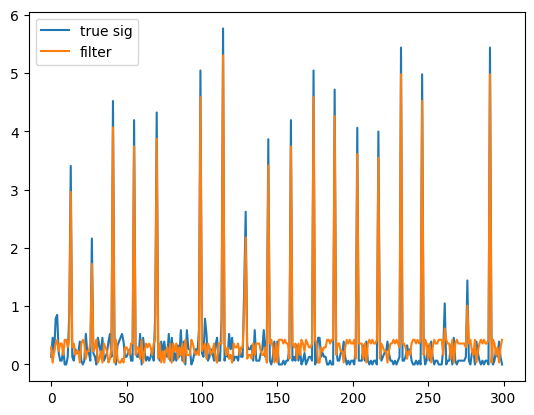

In [49]:
plt.plot(abs(signal[300:600]).reset_index(drop=True)/1e6, label="true sig")
plt.plot(abs(filtered_outputs), label="filter")
plt.legend()

In [129]:
def detrend_ecg(ecg_signal, smoothing_parameter=300):
    return np.convolve(ecg_signal, np.ones(smoothing_parameter) / smoothing_parameter, mode='same')

def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 

            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list

def smooth_ecg(ecg):
        ecg[" ECG"] = detrend_ecg(ecg[" ECG"]) #detrend the signal
        ecg["ECG_norm"] = (ecg[" ECG"] - ecg[" ECG"].mean()) / ecg[" ECG"].std() #Normalise
        #ecg["ECG_norm"] = (ecg[" ECG"] - ecg[" ECG"].min()) / (ecg[" ECG"].max() - ecg[" ECG"].min())
        ecg["ECG_MV"] = moving_average(ecg["ECG_norm"], 5) #moving average
        #ecg = ecg.loc[idx.iloc[0].idx_sig+1:idx.iloc[-1].idx_sig+1] # start at the first frame of video
        return ecg["ECG_MV"]

In [130]:
filtered = smooth_ecg(abs(signal[300:600]))

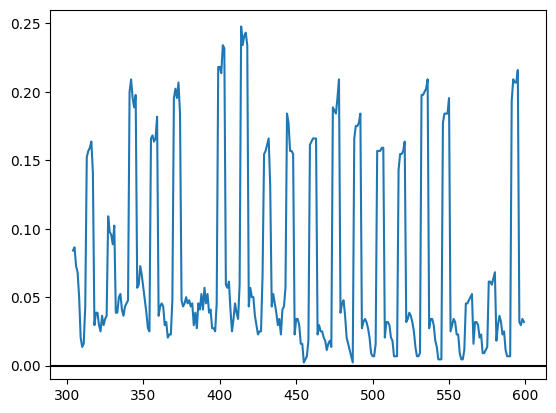

In [131]:
plt.plot(filtered)
plt.axhline(y=0, color='k')

In [132]:
model_output = [0.4746, 0.5020, 0.5101, 0.4705, 0.4552, 0.4730, 0.4730, 0.4810, 0.4722,
         0.4116, 0.5513, 0.5464, 0.6182, 0.4689, 0.4568, 0.4447, 0.4697, 0.4915,
         0.4996, 0.4802, 0.4754, 0.4810, 0.4786, 0.4713, 0.4689, 0.4463, 0.4923,
         0.4859, 0.5109, 0.4576, 0.4528, 0.4366, 0.4625, 0.4939, 0.5141, 0.5028,
         0.4835, 0.4730, 0.4560, 0.4568, 0.4649, 0.3777, 0.5287, 0.5254, 0.6231,
         0.4657, 0.4407, 0.4431, 0.4794, 0.5157, 0.5198, 0.5028, 0.4843, 0.4738,
         0.4681, 0.4754, 0.4835, 0.3963, 0.4157, 0.4124, 0.4891, 0.4487, 0.4391,
         0.4479, 0.4907, 0.4972, 0.4915, 0.4625, 0.4722, 0.4657, 0.4794, 0.4794,
         0.4084, 0.5400, 0.5246, 0.5916, 0.4528, 0.4520, 0.4471, 0.4794, 0.5044,
         0.5222, 0.4875, 0.4794, 0.4786, 0.4859, 0.4826, 0.4713, 0.4762, 0.4584,
         0.4617, 0.4496, 0.4544, 0.4463, 0.4697, 0.4972, 0.5141, 0.4939, 0.4746,
         0.4730, 0.4697, 0.4665, 0.4528, 0.4374, 0.4447, 0.4584, 0.4730, 0.4617,
         0.4447, 0.4641, 0.4770, 0.4956, 0.4810, 0.4891, 0.4794, 0.4826, 0.4738,
         0.3810, 0.5351, 0.5343, 0.6287, 0.4617, 0.4544, 0.4552, 0.4931, 0.5077,
         0.5036, 0.4794, 0.4754, 0.4826, 0.4883, 0.4730, 0.3277, 0.3923, 0.3955,
         0.5521, 0.4641, 0.4568, 0.4383, 0.4665, 0.4802, 0.4915, 0.4794, 0.4843,
         0.4843, 0.4802, 0.4681, 0.3955, 0.3987, 0.4052, 0.4738, 0.4592, 0.4512,
         0.4649, 0.4956, 0.5061, 0.4931, 0.4730, 0.4786, 0.4713, 0.4705, 0.4649,
         0.4415, 0.4512, 0.4342, 0.4552, 0.4415, 0.4447, 0.4633, 0.4802, 0.4899,
         0.4835, 0.4730, 0.4722, 0.4625, 0.4576, 0.4326, 0.5028, 0.5093, 0.5408,
         0.4762, 0.4600, 0.4399, 0.4584, 0.4730, 0.4948, 0.4859, 0.4770, 0.4730,
         0.4730, 0.4810, 0.3269, 0.4576, 0.4625, 0.6053, 0.4673, 0.4544, 0.4673,
         0.4883, 0.4939, 0.4883, 0.4657, 0.4528, 0.4504, 0.4471, 0.4504, 0.4383,
         0.4262, 0.4407, 0.4625, 0.4705, 0.4536, 0.4697, 0.4915, 0.5052, 0.4996,
         0.4939, 0.4931, 0.4883, 0.4762, 0.3648, 0.5004, 0.5036, 0.6158, 0.4633,
         0.4487, 0.4487, 0.4891, 0.5077, 0.5028, 0.4730, 0.4665, 0.4794, 0.4762,
         0.4818, 0.3430, 0.4802, 0.4754, 0.6005, 0.4617, 0.4552, 0.4617, 0.4810,
         0.4883, 0.4907, 0.4754, 0.4875, 0.4722, 0.4681, 0.4407, 0.4140, 0.4294,
         0.4471, 0.4851, 0.4600, 0.4431, 0.4504, 0.4697, 0.4786, 0.4883, 0.4818,
         0.4835, 0.4713, 0.4722, 0.3196, 0.4439, 0.4391, 0.5973, 0.4617, 0.4560,
         0.4625, 0.5020, 0.5109, 0.5036, 0.4649, 0.4673, 0.4738, 0.4770, 0.4528,
         0.4681, 0.4584, 0.4835, 0.4552, 0.4625, 0.4471, 0.4762, 0.4915, 0.5052,
         0.4931, 0.4891, 0.4891, 0.4746, 0.4625, 0.3107, 0.3866, 0.3939, 0.5383,
         0.4544, 0.4463, 0.4633]

model_output2 = [0.6805, 0.5680, 0.5419, 0.5061, 0.5915, 0.5797, 0.6128, 0.6149, 0.6213,
         0.6032, 0.5280, 0.6069, 0.5979, 0.6784, 0.5941, 0.6155, 0.6320, 0.6411,
         0.6384, 0.5616, 0.6528, 0.6373, 0.6843, 0.5840, 0.5856, 0.6059, 0.6149,
         0.6149, 0.5584, 0.6437, 0.6437, 0.6880, 0.5899, 0.5952, 0.6133, 0.6272,
         0.6400, 0.6411, 0.6485, 0.6155, 0.5867, 0.5664, 0.5765, 0.6011, 0.6155,
         0.6336, 0.6283, 0.5909, 0.5963, 0.5920, 0.6224, 0.6016, 0.6181, 0.6336,
         0.6565, 0.6411, 0.5749, 0.5696, 0.5605, 0.6064, 0.5760, 0.5893, 0.5925,
         0.6219, 0.6053, 0.5451, 0.5776, 0.5771, 0.6309, 0.5680, 0.5925, 0.6219,
         0.6613, 0.6587, 0.6032, 0.6965, 0.6741, 0.7173, 0.5856, 0.5963, 0.5941,
         0.6208, 0.6352, 0.5723, 0.6528, 0.6117, 0.6448, 0.5365, 0.5643, 0.6032,
         0.6293, 0.6421, 0.5765, 0.6619, 0.6443, 0.6864, 0.5867, 0.5920, 0.6043,
         0.6091, 0.6160, 0.5557, 0.6597, 0.6363, 0.6773, 0.5712, 0.5888, 0.6176,
         0.6256, 0.6357, 0.6251, 0.6853, 0.6533, 0.6491, 0.5797, 0.6000, 0.6171,
         0.6277, 0.6341, 0.6224, 0.6384, 0.6032, 0.5904, 0.5579, 0.5765, 0.6059,
         0.6267, 0.6459, 0.6400, 0.6608, 0.6331, 0.6208, 0.5797, 0.5808, 0.5995,
         0.6149, 0.6475, 0.6219, 0.6480, 0.6005, 0.5989, 0.5493, 0.5669, 0.5877,
         0.6048, 0.6235, 0.6256, 0.6224, 0.6096, 0.6021, 0.6144, 0.6347, 0.6544,
         0.6528, 0.6325, 0.6080, 0.5744, 0.5771, 0.5728, 0.5877, 0.5733, 0.5872,
         0.5925, 0.6181, 0.6117, 0.5861, 0.6037, 0.5941, 0.6240, 0.5845, 0.6080,
         0.6112, 0.6347, 0.6160, 0.5835, 0.5797, 0.5797, 0.6069, 0.5845, 0.5952,
         0.5952, 0.6251, 0.6219, 0.5765, 0.5733, 0.5669, 0.6197, 0.6048, 0.6213,
         0.6192, 0.6357, 0.6245, 0.5803, 0.5856, 0.5701, 0.6101, 0.5765, 0.6011,
         0.6139, 0.6405, 0.6283, 0.5611, 0.5893, 0.5824, 0.6288, 0.5813, 0.6139,
         0.6416, 0.6656, 0.6325, 0.5669, 0.5701, 0.5707, 0.6123, 0.5808, 0.5947,
         0.6064, 0.6181, 0.5973, 0.5456, 0.5712, 0.5755, 0.6213, 0.6021, 0.6325,
         0.6405, 0.6597, 0.6640, 0.6085, 0.6112, 0.5723, 0.6080, 0.5632, 0.5915,
         0.6011, 0.6155, 0.5904, 0.5525, 0.5557, 0.5563, 0.5979, 0.5925, 0.6171,
         0.6432, 0.6613, 0.6565, 0.5867, 0.6096, 0.5883, 0.6219, 0.5717, 0.5845,
         0.6075, 0.6357, 0.6427, 0.5851, 0.5691, 0.5403, 0.5813, 0.5717, 0.6075,
         0.6192, 0.6560, 0.6427, 0.6155, 0.5851, 0.5712, 0.5872, 0.5867, 0.6203,
         0.6320, 0.6533, 0.6315, 0.6059, 0.5824, 0.5691, 0.5781, 0.5739, 0.6059,
         0.6181, 0.6459, 0.6437, 0.6411, 0.6256, 0.6027, 0.5872, 0.5637, 0.5803,
         0.6005, 0.6288, 0.6203, 0.6197, 0.5989, 0.5856, 0.5584, 0.5589, 0.5851,
         0.6096, 0.6315, 0.6224]

In [133]:
filtered

300         NaN
301         NaN
302         NaN
303         NaN
304    0.084091
         ...   
595    0.215909
596    0.031818
597    0.029545
598    0.034091
599    0.031818
Name: ECG_MV, Length: 300, dtype: float64

/tmp/ipykernel_8353/1383056724.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg["ECG_norm"] = (ecg[" ECG"] - ecg[" ECG"].min()) / (ecg[" ECG"].max() - ecg[" ECG"].min())
/tmp/ipykernel_8353/1383056724.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg["ECG_MV"] = moving_average(ecg["ECG_norm"], 5) #moving average


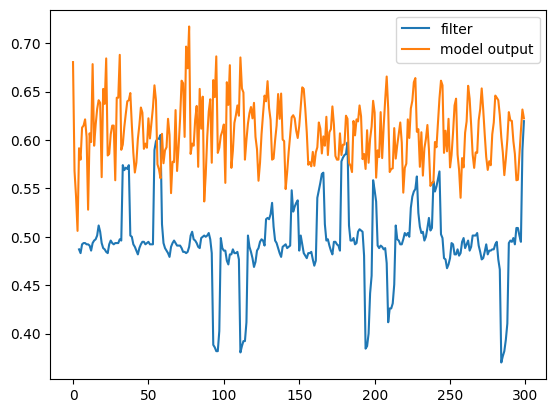

In [134]:
filtered = smooth_ecg(signal[0:300])
plt.plot(filtered, label="filter")
plt.plot(model_output2, label="model output")
plt.legend()

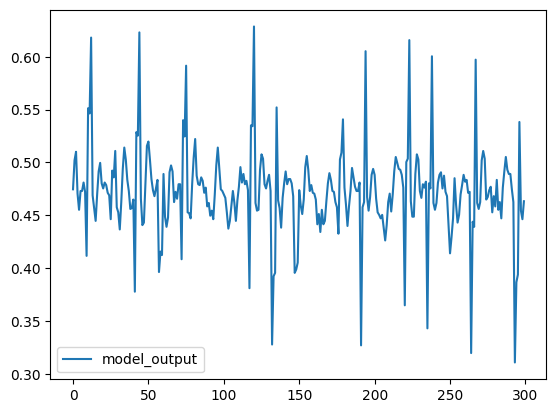

In [113]:
plt.plot(model_output, label="model_output")
plt.legend()

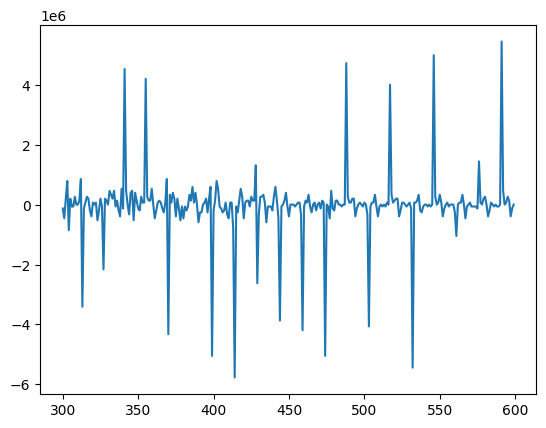

In [84]:
plt.plot(signal[300:600])